In [336]:
from IPython.display import Image, HTML
from util import *

In [73]:
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# ISDS

https://www.buzzfeed.com/chrishamby/not-just-a-court-system-its-a-gold-mine

# Wikileaks Cables

[Cablegate](https://wikileaks.org/plusd/?qproject[]=ps&qproject[]=cg&qproject[]=cc&qproject[]=fp&qproject[]=ee&q=&qtfrom=1978-01-01&qtto=1978-12-31#result)

"The United States diplomatic cables leak, widely known as Cablegate, began on Sunday, 28 November 2010 when WikiLeaks—a non-profit organization that publishes submissions from anonymous whistleblowers—began releasing classified cables that had been sent to the U.S. State Department by 274 of its consulates, embassies, and diplomatic missions around the world. Dated between December 1966 and February 2010, the cables contain diplomatic analysis from world leaders, and the diplomats' assessment of host countries and their officials." ([wikipedia](https://en.wikipedia.org/wiki/United_States_diplomatic_cables_leak))

https://file.wikileaks.org/file/cablegate/

In [243]:
records.iloc[0].text

'66BUENOSAIRES2481, EXTENDED NATIONAL JURISDICTIONS OVER HIGH SEASIf you are new to these pages, please read an introduction on the structure of a cable as well as how to discuss them with others. See also the FAQsUnderstanding cablesEvery cable message consists of three parts:The top box shows each cables unique reference number, when and by whom it originally was sent, and what its initial classification was.The middle box contains the header information that is associated with the cable. It includes information about the receiver(s) as well as a general subject.The bottom box presents the body of the cable. The opening can contain a more specific subject, references to other cables (browse by origin to find them) or additional comment. This is followed by the main contents of the cable: a summary, a collection of specific topics and a comment section.To understand the justification used for the classification of each cable, please use this WikiSource article as reference.Discussing 

In [258]:
records.shape

(354885, 1)

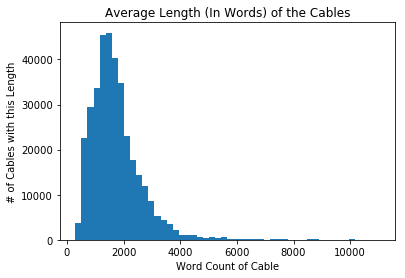

In [72]:
lengths = records.text.apply(lambda x: len(x.split()))
lengths.hist(bins=50)
plt.grid()
plt.title('Average Length (In Words) of the Cables')
plt.ylabel('# of Cables with this Length')
plt.xlabel('Word Count of Cable');

Your editor slaps this pile of documents on your desk and says "We need you to go through these files to get a sense of whats going on, and to pick the interesting ones."

### Who wants to go through all these 300,000 records by hand?

# Let's see if there are computational techniques we can use to get a better picture of what's going on 

# ===========================================
# Approach #1: Look at words
# ===========================================

## Word Counts

In [165]:
vec = CountVectorizer()
counts = vec.fit_transform(records.iloc[:1000].text)

## total counts throughout corpus

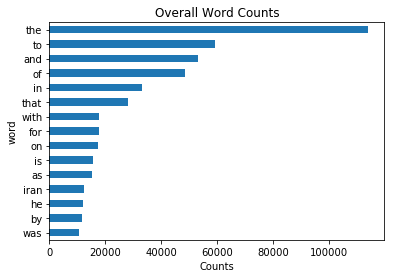

In [172]:
plot_counts(vec, counts, title='Overall Word Counts')

## cut out the words that appear in nearly all of the documents

In [106]:
vec = CountVectorizer(min_df=.01, max_df=.8)
counts = vec.fit_transform(records.text.iloc[:50000])

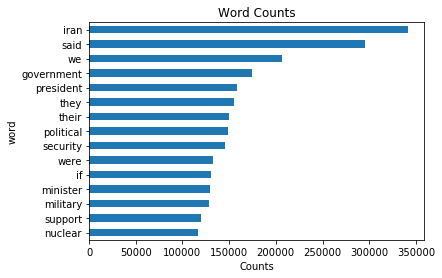

In [149]:
plot_counts(vec, counts)

## ====================================================
## Approach #1b. Go a bit deeper: Look at different types of words
## ====================================================

# Part-of-Speech Tagging

https://spacy.io/api/annotation#pos-tagging

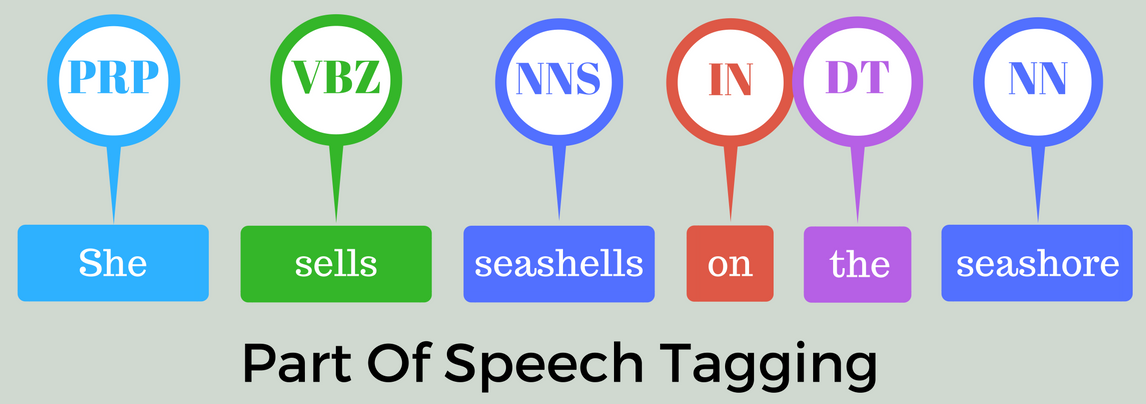

In [338]:
Image('img/part_of_speech_tagging.png')

### Example bit of an annotated cable:

In [165]:
for word, pos in pos_tagging.iloc[0][100:125]:
    print "%s \t\t\t %s" % (word, pos)

. 			 PUNCT
the 			 DET
bottom 			 ADJ
box 			 NOUN
present 			 VERB
the 			 DET
body 			 NOUN
of 			 ADP
the 			 DET
cable 			 NOUN
. 			 PUNCT
the 			 DET
open 			 NOUN
can 			 VERB
contain 			 VERB
a 			 DET
much 			 ADV
specific 			 ADJ
subject 			 NOUN
, 			 PUNCT
reference 			 NOUN
to 			 ADP
other 			 ADJ
cable 			 NOUN
( 			 PUNCT


### What are the most common verbs?

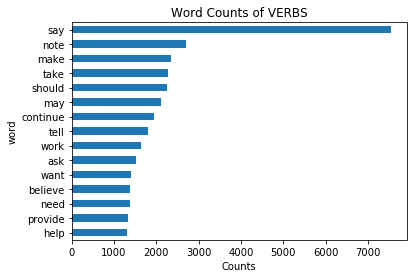

In [138]:
verb_pipe = make_pipe('VERB')
verb_counts = verb_pipe.fit_transform(pos_tagging)
plot_counts(verb_pipe.named_steps['vec'], verb_counts, title='Word Counts of VERBS')

### Let's investigate the "help" verb. Who is helping? What is going on?

Options:

1. Search through all the documents with "help".

2. Get some more high-level views

In [366]:
print 'Types of Part-of-speech available to look at:'
print
for tag in sorted(list(set(map(lambda x: x[1], pos_tagging.iloc[0])))):
    print tag

Types of Part-of-speech available to look at:

ADJ
ADP
ADV
CCONJ
DET
INTJ
NOUN
NUM
PART
PRON
PROPN
PUNCT
SPACE
SYM
VERB


### Proper Nouns

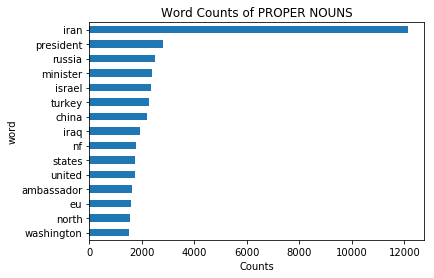

In [139]:
proper_noun_pipe = make_pipe('PROPN')
proper_noun_counts = proper_noun_pipe.fit_transform(pos_tagging)
plot_counts(proper_noun_pipe.named_steps['vec'], proper_noun_counts, title='Word Counts of PROPER NOUNS')

This doesn't give us enough specificity.

# Named Entity Recognition

https://spacy.io/usage/linguistic-features#entity-types

### Example Sentence: "Apple is looking at buying a U.K. startup for $1 billion."

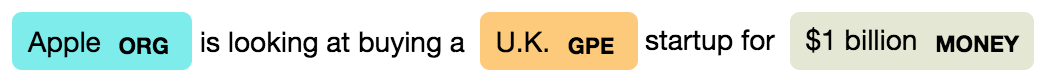

In [357]:
Image('img/pos_render_1.png')

Types of named entities:

CARDINAL,
DATE,
EVENT,
FAC,
GPE,
LANGUAGE,
LAW,
LOC,
MONEY,
NORP,
ORDINAL,
ORG,
PERCENT,
PERSON,
PRODUCT,
QUANTITY,
TIME,
WORK_OF_ART

### Person

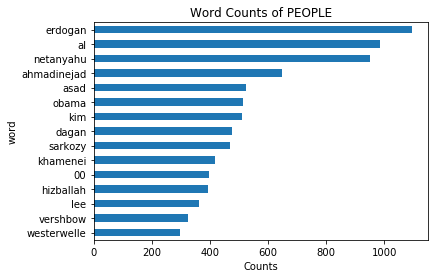

In [140]:
people_pipe = make_pipe('PERSON')
people_counts = people_pipe.fit_transform(named_entities)
plot_counts(people_pipe.named_steps['vec'], people_counts, title='Word Counts of PEOPLE')

### Geo political Entity

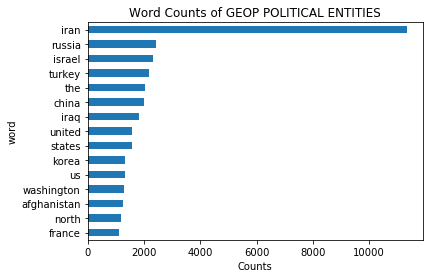

In [141]:
geo_political_pipe = make_pipe('GPE')
geo_political_counts = geo_political_pipe.fit_transform(named_entities)
plot_counts(geo_political_pipe.named_steps['vec'], geo_political_counts, title="Word Counts of GEO POLITICAL ENTITIES")

### Now we can look at: which documents talk about:
1. __Person:__ Obama, 
2. __Verb:__ help, and
3. __Geo-political Entity:__ Iran?

In [142]:
obama_help_iran_docs = set(np.where((people_counts[:, people_pipe.named_steps['vec'].vocabulary_['obama']] > 0).todense())[0]) & \
    set(np.where((verb_counts[:, verb_pipe.named_steps['vec'].vocabulary_['help']] > 0).todense())[0]) & \
    set(np.where((geo_political_counts[:, geo_political_pipe.named_steps['vec'].vocabulary_['iran']] > 0).todense())[0])

In [166]:
"%d documents out of 1000" % len(obama_help_iran_docs)

'164 documents out of 1000'

#### example document

In [134]:
records.iloc[list(obama_help_iran_docs)[0]][0][2000:5000]

' E C R E T SECTION 01 OF 04 TEL AVIV 002760  SIPDIS  TREASURY FOR LEVEY, S. ATHENS FOR PURCELL, A.  E.O. 12958: DECL: 12/10/2018 TAGS: KTFN EFIN ECON KWBG IR ISSUBJECT: U/S LEVEY REASSURES GOI THAT NO MOMENTUM WILL BE LOST IN THE FIGHT AGAINST TERROR FINANCE  Classified By: A/DCM Marc Sievers for reasons 1.4 (b) and (d)  ------- SUMMARY -------  1.(S) In a visit to Israel on 16-17 November, Treasury Under Secretary for Terrorism and Financial Intelligence, Stuart A. Levey, reassured GOI officials that no momentum would be lost in USG efforts to combat terrorist financing or to pressure Iran during the transition to a new US administration in January. In meetings with Foreign Minister Tzipi Livni, Mossad Director Meir Dagan, National Security Council Chairman Dani Arditi, and others, U/S Levey emphasized recent U.S. designations against the Union of Good, the Islamic Republic of Iran Shipping Lines (IRISL), and the recent revocation of Iran\'s "U-Turn" license. In response to GOI offic

### cool! 

__Uses of this technique in practice:__

Crawled 15,000 NYTimes articles published over the 2015-2016 election season. 

https://www.nytimes.com/2016/11/04/insider/19-countries-43-states-327-cities-mapping-the-timess-election-coverage.html

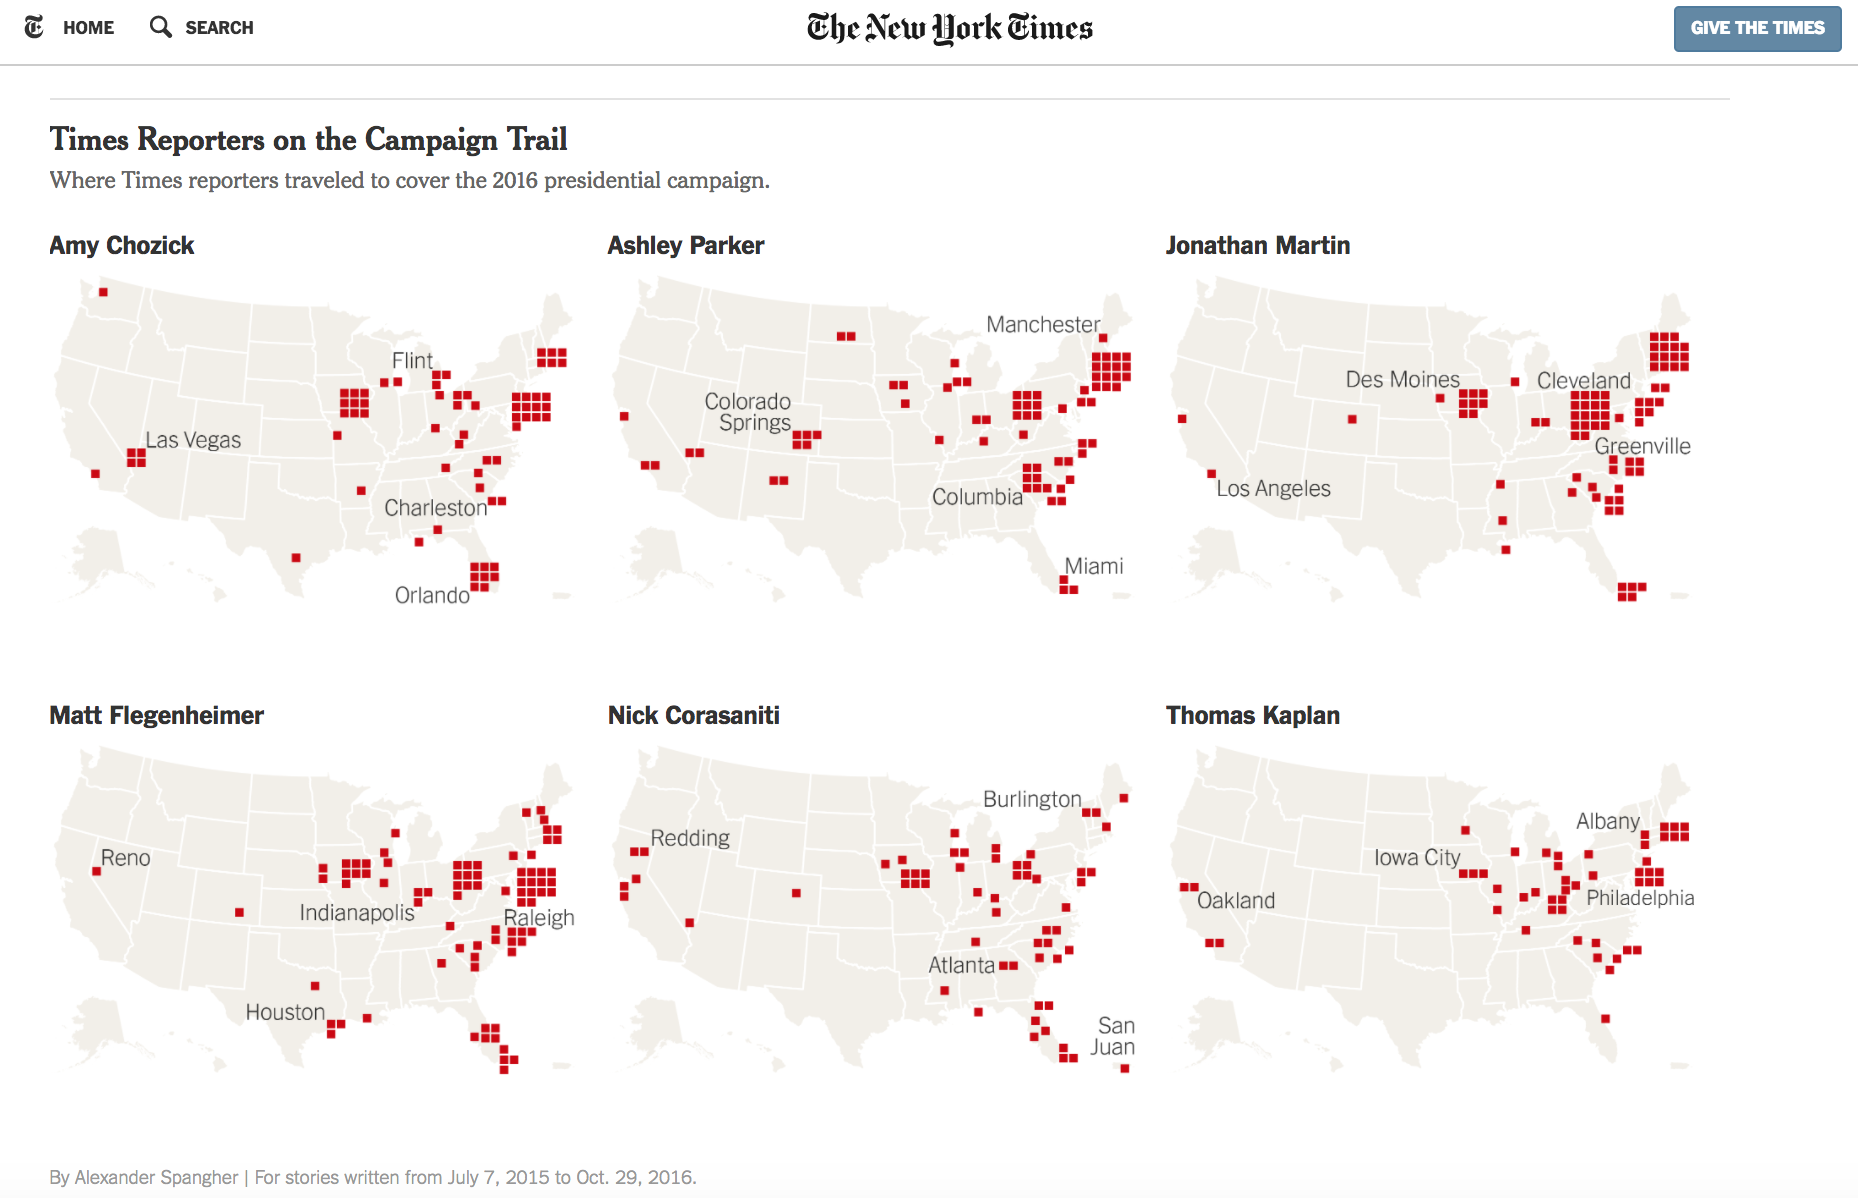

In [265]:
Image(filename='img/spangher_political_reporter_graphic.png', width=1000)

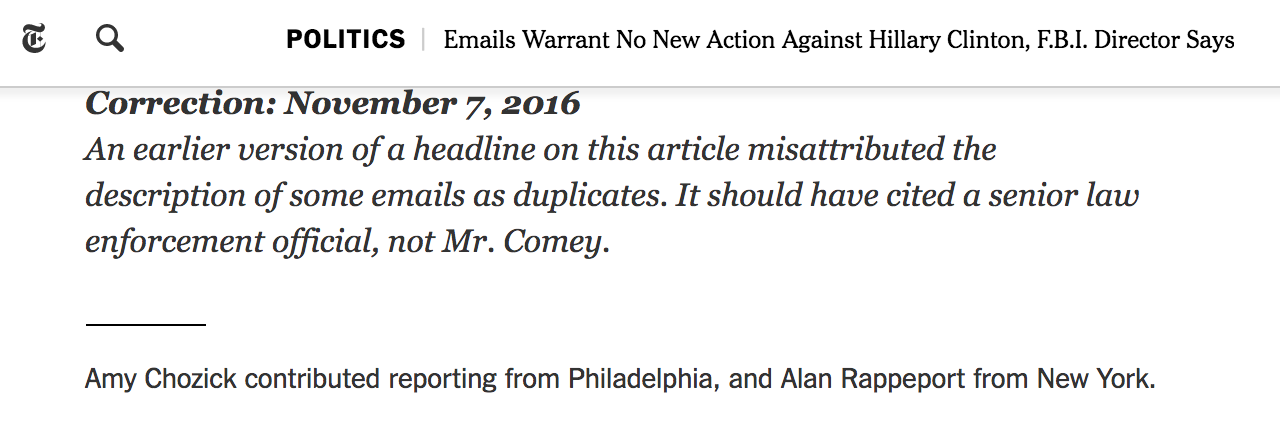

In [269]:
Image(filename='img/contribline_example.png', width=600)

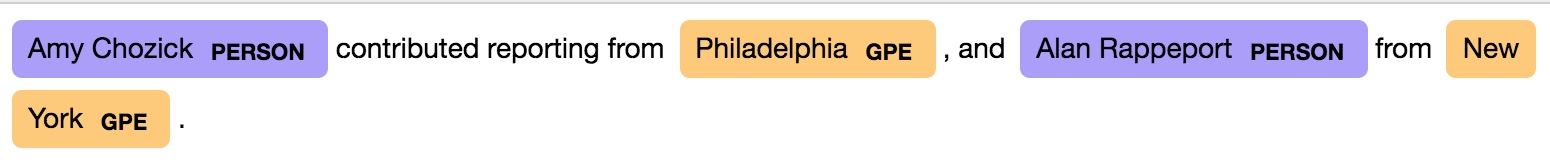

In [355]:
Image('img/pos_render_2.png')

__Another use case:__

In Jennifer Golan and Shane Shifflet story, _“Federal
Judge’s Rulings Favored Companies in which he Owned Stock”_ for
the Center for Investigative Reporting, the journalists needed __lists of companies owned by federal judges__.

Shifflet transcribed California federal judges’
“statement of economic interest" disclosures to __generate lists of
companies in which they owned stock__. He then scraped the
PACER database for every case those judges presided over and __used NER to generate a per-judge list of the
entities involved__. By comparing
these lists the reporters were able to find cases in which judges
had ruled favorably for companies in which they owned stock.

https://www.publicintegrity.org/2014/04/28/14630/federal-judges-plead-guilty

# ============================================= #

# Approach #2

# =============================================

## Topic Modeling

Topic modeling extracts the topics that are present in a corpus.

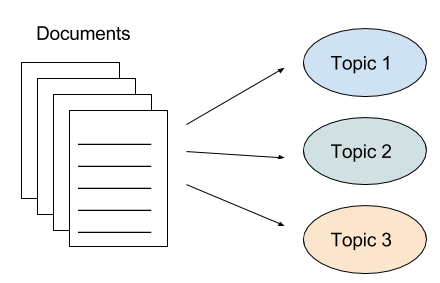

In [326]:
Image('img/topic_modeling_visualization.png')

Each document in the corpus can then be described in terms of it's topic breakdown. For example, if a corpus consists of two topics, __Art__ and __Politics__, then documents in this corpus can be described as a combination these.

Here's an example of topic modeling in the context of NYTimes published in the summer of 2015. 

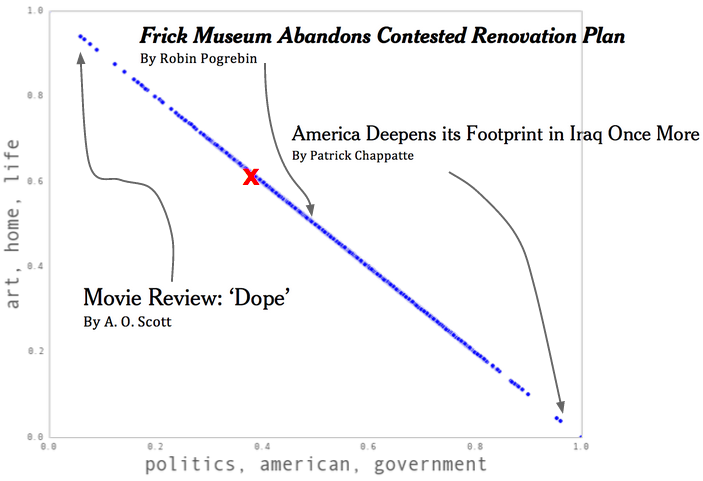

In [330]:
Image('img/nytimes_example.png', width=600)

For more information, see here: https://open.blogs.nytimes.com/2015/08/11/building-the-next-new-york-times-recommendation-engine/

### What topics are cables mainly talking about? 

In [297]:
topic_word = re.compile(r'[0-9A-Za-z ]*"([A-za-z]+)"[0-9A-Za-z ]*')
for topic_number, topic_words in enumerate([
    re.findall(topic_word, topic) for i, topic in lda_model.show_topics(num_topics=45)
]):
    print "topic # %d" % (topic_number + 1)
    print '   '.join([word for word in topic_words if 'xxxx' not in word])
    print

topic # 1
brazil   brasilia   brazilian   lula   cable   gob   said   amorim   ambassador   president

topic # 2
china   chinese   cable   said   africa   beijing   reference   new   also

topic # 3
afghanistan   would   nato   afghan   said   cable   kabul   karzai   security   also

topic # 4
uae   efforts   terrorist   security   iraq   including   plans   information   groups   us

topic # 5
pakistan   military   cable   egypt   zardari   security   government   general   islamabad   also

topic # 6
scottish   swiss   scotland   snp   muralt   hannibal   ambuhl   sweden   independence   salmond

topic # 7
russia   russian   cable   moscow   putin   french   political   would   us   france

topic # 8
lukashenko   sinai   ministry   minister   president   royg   minsk   university

topic # 9
bouteflika   portugal   algeria   portuguese   eta   morocco   said   welch   ringera   sahara

topic # 10
north   korea   would   missile   said   dprk   kosovo   defense   cable   states

topic

### let's look at documents in topic #18: [ gas   oil   bp   company   energy ]

#### Question #1: How many documents index highly for topic 2?

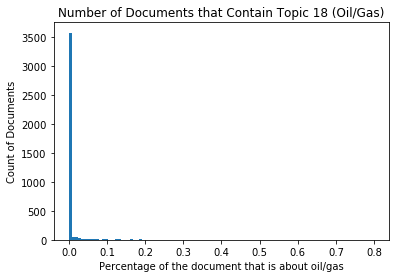

In [379]:
theta_df['topic_18'].hist(bins=100)
plt.grid('off')
plt.title('Number of Documents that Contain Topic 18 (Oil/Gas)')
plt.ylabel('Count of Documents')
plt.xlabel('Percentage of the document that is about oil/gas');

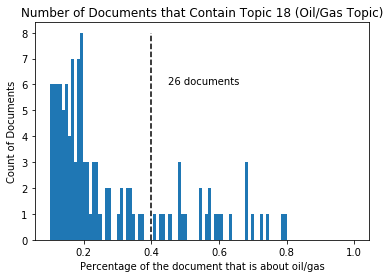

In [380]:
theta_df['topic_18'].hist(bins=100, range=(.1, 1))
plt.grid('off')
plt.title('Number of Documents that Contain Topic 18 (Oil/Gas Topic)')
plt.ylabel('Count of Documents')
plt.xlabel('Percentage of the document that is about oil/gas')
plt.vlines(.4, 0, 8, linestyles='dashed')
plt.text(.45, 6, '%d documents' % (theta_df['topic_18'] > .4).sum());

In [371]:
for record in theta_df.sort_values('topic_18', ascending=False).head(3).text:
    print record[4000:7000]
    print 
    print 

RO1050PP RUEHAG RUEHROVDE RUEHKB #0947/01 2821027ZNY CCCCC ZZHP 081027Z OCT 08FM AMEMBASSY BAKUTO RUEHC/SECSTATE WASHDC PRIORITY 0123INFO RUCNCIS/CIS COLLECTIVERUCNMEM/EU MEMBER STATESRHMFISS/CDR USEUCOM VAIHINGEN GERUEAIIA/CIA WASHINGTON DCRHEBAAA/DEPT OF ENERGY WASHDCRUEKDIA/DIA WASHDCRUEKJCS/JOINT STAFF WASHDCRHEHNSC/NSC WASHDCRHEHAAA/WHITE HOUSE WASHDCWednesday, 08 October 2008, 10:27C O N F I D E N T I A L SECTION 01 OF 03 BAKU 000947 SIPDIS EO 12958 DECL: 09/06/2018 TAGS PGOV, PREL, AJ, ENRG, TU SUBJECT: AZERBAIJAN SEEKS TO DEVELOP ACG DEEP GAS, CAN SUPPLY GEORGIA WITH WINTER GASREF: A. A) BAKU 919  B. B) BAKU 897  C. C) BAKU 883Classified By: Ambassador Anne E. Derse, Reasons 1.4 (b,d)1. (C) SUMMARY: BP Azerbaijan President Bill Schrader told USG interlocutors that there will be plenty of gas for Azerbaijan to sell to Georgia this winter. This is a result of oil production problems at the offshore ACG oil mega-field, which continues to cost the GOAJ tens of millions of dollars i

__Uses of this technique in practice:__

For their 2014 story “The Echo Chamber,” reporters Joan
Biskupic, Janet Roberts and John Shiffman of Reuters wanted to
show how a small group of elite lawyers have argued most of the
cases before the U.S. Supreme Court. 

They assembled the 10,300 petitions to the court filed by over 17,000 lawyers from
2004 to 2012. Of these, only 528 cases were heard.
__The reporters wanted to break down the number of accepted cases
by type, for example whether filed by a business, individual, or
government agency.__

They applied topic modeling and after some experimentation
found that 40 topics seemed to capture the structure of the
petitions most clearly. __They examined the generated topics and
manually labeled them with categories such as environmental
regulation, congressional intent, utilities, etc.__

https://www.reuters.com/investigates/special-report/scotus/

Topic modeling for article recommendations:

https://open.blogs.nytimes.com/2015/08/11/building-the-next-new-york-times-recommendation-engine/

# ============================================
# Approach 3: “I’ll know it when I see it”
# ============================================

__Approach:__
1. Start labeling documents:
    1. "This is an example of what I __AM__ looking for"
    2. "This is an example of what I'm __NOT__ looking for"
2. Train a model with these examples

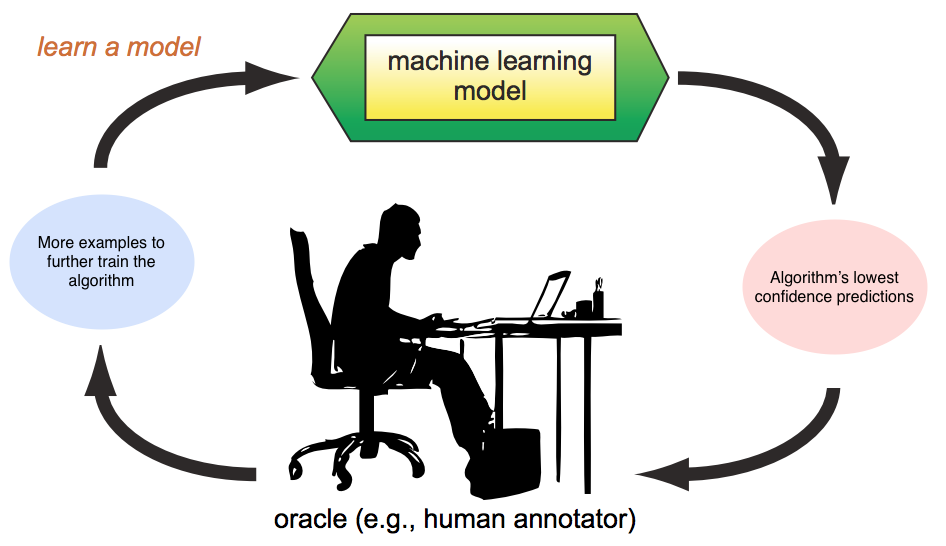

In [332]:
Image("img/active_learning_example.png", width=600)

Choose the best examples to label

In [312]:
df, pipe = setup_active_learning(records_slim)

In [316]:
aucs = []
# gather more samples 
for t in range(2):
    df, pipe, score = run_active_learning(df, pipe, batch_size=10)
    aucs.append(score)

### Accuracy over time

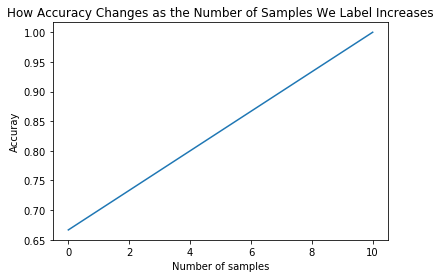

In [317]:
plt.plot(np.arange(len(aucs)) * 10, aucs)
plt.ylabel('Accuray')
plt.xlabel("Number of samples")
plt.title('How Accuracy Changes as the Number of Samples We Label Increases');

#### We can now interrogate our model and ask: what _makes_ something interesting?

In [334]:
t = pipe.named_steps['model']
vec = pipe.named_steps['vec']
vocab = np.array(sorted(vec.vocabulary_.keys()))
list(vocab[np.argsort(-t.coef_[0,:])[:10]])

[u'german',
 u'berlin',
 u'unscr',
 u'shig',
 u'1747',
 u'computers',
 u'turkey',
 u'authorities',
 u'siemens',
 u'uav']

### now use this model to predict the most interesting piece that I haven't looked at yet, and show it to me

In [323]:
df[df.class_label==1]

,text,y,max_p,class_label
index,,,,
2009/10/09ANKARA1472.html,"09ANKARA1472, SCENESETTER: YOUR VISIT TO TURK...",NaN,0.603837,1.0
2009/11/09ANKARA1594.html,"09ANKARA1594, TURKISH MEDIA REACTIONIf you are...",NaN,0.524122,1.0
2009/12/09ISTANBUL440.html,"09ISTANBUL440, TURKEY-IRAN RELATIONS: MOTIVATI...",NaN,0.729873,1.0
2010/01/10ANKARA126.html,"10ANKARA126, SECRETARY GATES' TURKEY BILATERAL...",NaN,0.687912,1.0
2010/01/10ANKARA87.html,"10ANKARA87, WHAT LIES BENEATH ANKARA'S NEW FOR...",NaN,0.651136,1.0
2010/02/10ANKARA251.html,"10ANKARA251, SECRETARY OF DEFENSE GATES'S MEET...",NaN,0.617061,1.0
2010/02/10USNATO52.html,CMGTDJEGEFINERELETRDETTCECONEINVEAGREUNEUENRGE...,NaN,0.522916,1.0
2002/11/02ANKARA8305.html,DushanbeEmbassy DublinEmbassy DohaEmbassy Djib...,NaN,0.611190,1.0
2006/06/06ANKARA3352.html,DushanbeEmbassy DublinEmbassy DohaEmbassy Djib...,NaN,0.508832,1.0


__Uses of this technique in practice:__

For the story “License to Betray” Carrie Teegardin, Danny
Robbins, Jeff Ernsthausen and Ariel Hart of the Atlanta JournalConstitution
scraped over __100,000 doctor disciplinary records
from every state__, looking for instances where doctors who had
sexually abused patients were allowed to continue practice.


Ernsthausen drastically reduced this pile by applying machine
learning to __identify reports that were likely to concern sexual
abuse__. First the __reporters manually labelled a few hundred
documents to produce a training set__. After trying several different
classifiers including naïve Bayes on all TF-IDF features, he
settled on logistic regression over a hand-selected set of relevant
terms. This included both positive terms such as “sexual” and
negative terms that suggested the incident concerned something
else such as “narcotic.” The final classifier had an area under
ROC of >0.9.

__Then, they trained a model and selected only those documents with a rated probability of 0.5 or
greater of concerning sexual abuse produced a set of 6,000
documents__ which the reporters then read and coded manually
(interactive techniques, clarity and accuracy). In this way they
were able to identify substantially all cases within the larger set.

http://doctors.ajc.com/doctors_sex_abuse/

__Newsroom tips:__

Surface tips that are more likely to be interesting to journalists.

# Appendix

Other approaches in the field:

__Great paper__:

* Ways in which journalists have used these techniques previously: https://journalism.stanford.edu/cj2016/files/What%20do%20journalists%20do%20with%20documents.pdf

__Topic Modeling__
* Jonathan Stray: Using TF-IDF to create graphs in large document corpuses http://jonathanstray.com/a-full-text-visualization-of-the-iraq-war-logs


* Scientific paper: <u>Machine Learning meets Data-Driven Journalism:
Boosting International Understanding and Transparency in News Coverage:</u> https://arxiv.org/pdf/1606.05110.pdf


__Active Learning__

* Active Learning for entity deduplication: http://cvs.cs.umd.edu/class/spring2012/cmsc828L/Papers/SarawagiKDD2002.pdf
* Same thing, but just a summary of a talk: https://odsc.com/training/portfolio/applying-active-learning-algorithm-entity-deduplication-graph-data
* Great Active Learning Literature Review: http://burrsettles.com/pub/settles.activelearning.pdf

__Other Machine Learning Techniques for journalism__

* Using auto-summarization for corpus research: http://www.storybench.org/how-machine-learning-could-change-journalism/
* http://datadrivenjournalism.net/news_and_analysis/machine_learning_and_data_journalism_can_support_democracy

* Toolkit for Automatic classification, slugline generation, trend detection, summarization, data gathering : https://www.iit.demokritos.gr/sites/default/files/a_multi-lingually_applicable_journalist_toolset_for_the_big-data_era_yds_july2016.pdf

__NLP/ML and Journalism Conferences:__
* 2017: http://nlpj2017.fbk.eu/accepted-papers
* 2016: http://nlpj2016.fbk.eu/accepted-papers

__Textbooks:__

* [The Data Journalism Handbook](https://www.amazon.com/Data-Journalism-Handbook-Journalists-Improve/dp/1449330061/)
* [Introduction to Information Retrieval](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf)